# Data preparation

In [ ]:
from google.colab import drive
import pickle
import numpy as np
import cv2

def load_images(CURRENT, CONTENTS, CATEGORIES):
    CNT_IMG = []
    for content in CONTENTS:
        for category in CATEGORIES:
            Path = os.path.join(CURRENT, content + '-' + category)
            if not os.path.exists(Path):
                print(f"Path does not exist: {Path}")
                continue
            for i, file in enumerate(os.listdir(Path)):
                img_array = cv2.imread(os.path.join(Path, file))  # 옵션을 제거하여 컬러 이미지로 읽기
                if img_array is None:
                    print(f"Could not read image: {os.path.join(Path, file)}")
                    continue
                CNT_IMG.append([img_array, CONTENTS.index(content), CATEGORIES.index(category), file])
    return CNT_IMG

# Load data
drive.mount('/content/drive')
# CURRENT = './CNT/'
CURRENT = '/content/drive/My Drive/CNT/'
CONTENTS = ['0','0.05', '0.1', '0.2', '0.4']
METHODS = ['Shear', 'Sonic']
CNT_IMG = load_images(CURRENT, CONTENTS, METHODS)
print(f"Number of images loaded: {len(CNT_IMG)}")

with open('/content/drive/My Drive/CNT_IMG_color.pkl', 'wb') as file:
    pickle.dump(CNT_IMG, file)

In [ ]:
# Load images
drive.mount('/content/drive')
with open('/content/drive/My Drive/CNT_IMG_color.pkl', 'rb') as file:
    CNT_IMG = pickle.load(file)  # list of (image, content, method, name)


target_crop = (224,224)
# target_crop = (448,448)
# target_crop = (672,672)
# target_crop = (896,896)
# target_crop = (1080,1080)

crop_h, crop_w = target_crop

# CNT_IMG = list of (img_array, content, method, name)
contents = np.array([s[1] for s in CNT_IMG])  # stratification 기준

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import StratifiedKFold

def crop_image(img_array, content, method, name, crop_h, crop_w):
    H, W = img_array.shape[:2]
    crops = []

    if crop_h >= 1080:
        num_h, num_w = 1, 3
        stride_h = 0
        stride_w = (W - crop_w) // (num_w - 1) if num_w > 1 else 0

        for j in range(0, W - crop_w + 1, stride_w):
            sub_img = img_array[0:crop_h, j:j+crop_w]
            if sub_img.shape[:2] == (crop_h, crop_w):
                crops.append([sub_img, content, method, name])

    elif crop_h >= 672 or crop_w >= 672:
        num_h, num_w = 2, 3
        stride_h = (H - crop_h) // (num_h - 1) if num_h > 1 else 0
        stride_w = (W - crop_w) // (num_w - 1) if num_w > 1 else 0

        for i in range(0, H - crop_h + 1, stride_h):
            for j in range(0, W - crop_w + 1, stride_w):
                sub_img = img_array[i:i+crop_h, j:j+crop_w]
                if sub_img.shape[:2] == (crop_h, crop_w):
                    crops.append([sub_img, content, method, name])

    else:
        stride_h, stride_w = crop_h, crop_w
        for i in range(0, H - crop_h + 1, stride_h):
            for j in range(0, W - crop_w + 1, stride_w):
                sub_img = img_array[i:i+crop_h, j:j+crop_w]
                if sub_img.shape[:2] == (crop_h, crop_w):
                    crops.append([sub_img, content, method, name])

    return crops


outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_fold_sets = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(CNT_IMG, contents)):
    print(f"\n🧪 Fold {fold+1}/5")

    train_imgs = [CNT_IMG[i] for i in train_idx]
    test_imgs = [CNT_IMG[i] for i in test_idx]

    SMALL_TRAIN = []
    SMALL_TEST = []

    for img_array, content, method, name in train_imgs:
        SMALL_TRAIN.extend(crop_image(img_array, content, method, name, crop_h, crop_w))
    for img_array, content, method, name in test_imgs:
        SMALL_TEST.extend(crop_image(img_array, content, method, name, crop_h, crop_w))

    outer_fold_sets.append((SMALL_TRAIN, SMALL_TEST))

print(f"\n✅ Total outer folds: {len(outer_fold_sets)}")


🧪 Fold 1/5

🧪 Fold 2/5

🧪 Fold 3/5

🧪 Fold 4/5

🧪 Fold 5/5

✅ Total outer folds: 5


In [ ]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

def random_color_adjust(img):
    # img: tf.Tensor of shape (H, W, 3), dtype=tf.float32, range [0, 1]
    # Brightness
    brightness_delta = random.uniform(-0.1, 0.1)
    img = tf.image.adjust_brightness(img, delta=brightness_delta)
    # Contrast
    contrast_factor = random.uniform(0.8, 1.2)
    img = tf.image.adjust_contrast(img, contrast_factor)
    # Gamma
    gamma = random.uniform(0.8, 1.2)
    img = tf.image.adjust_gamma(img, gamma=gamma)
    # Hue
    hue_delta = random.uniform(-0.02, 0.02)
    img = tf.image.adjust_hue(img, delta=hue_delta)
    # Saturation
    saturation_factor = random.uniform(0.8, 1.2)
    img = tf.image.adjust_saturation(img, saturation_factor)

    if random.random() < 0.5:
      img = tf.image.flip_left_right(img)
    if random.random() < 0.5:
      img = tf.image.flip_up_down(img)

    if random.random() < 0.25:
        img = tf.image.rot90(img, k=1)
    elif random.random() < 0.25:
        img = tf.image.rot90(img, k=2)
    elif random.random() < 0.25:
        img = tf.image.rot90(img, k=3)

    return img

In [ ]:
def prepare_rgb_image_dataset(train_imgs, test_imgs, target_size=(224, 224)):
    import numpy as np
    import cv2
    import tensorflow as tf

    def extract_rgb_image(img):
        img_resized = cv2.resize(img, target_size)
        rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        return rgb

    def safe_random_color_adjust(img):
        aug = random_color_adjust(tf.convert_to_tensor(img / 255.0, dtype=tf.float32)).numpy() * 255.0
        if np.isnan(aug).any() or np.isinf(aug).any():
            return None
        return np.clip(aug, 0, 255).astype(np.uint8)

    rgb_train, y_content_train, y_disp_train = [], [], []
    for img, content, method, name in train_imgs:
        r = extract_rgb_image(img)
        rgb_train.append(r)
        y_content_train.append(content)
        y_disp_train.append(method)
        for _ in range(11):
            aug_img = safe_random_color_adjust(r)
            if aug_img is not None:
                r_aug = extract_rgb_image(aug_img)
                rgb_train.append(r_aug)
                y_content_train.append(content)
                y_disp_train.append(method)

    rgb_test, y_content_test, y_disp_test = [], [], []
    for img, content, method, name in test_imgs:
        r = extract_rgb_image(img)
        rgb_test.append(r)
        y_content_test.append(content)
        y_disp_test.append(method)

    rgb_train = np.array(rgb_train)  # shape: (N, 256, 256, 3)
    rgb_test = np.array(rgb_test)

    return rgb_train, np.array(y_content_train), np.array(y_disp_train), \
           rgb_test, np.array(y_content_test), np.array(y_disp_test)


In [ ]:
def prepare_rgb_image_test_dataset(train_imgs, test_imgs, target_size=(224, 224)):
    import numpy as np
    import cv2
    import tensorflow as tf

    def extract_rgb_image(img):
        img_resized = cv2.resize(img, target_size)
        rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        return rgb

    def safe_random_color_adjust(img):
        aug = random_color_adjust(tf.convert_to_tensor(img / 255.0, dtype=tf.float32)).numpy() * 255.0
        if np.isnan(aug).any() or np.isinf(aug).any():
            return None
        return np.clip(aug, 0, 255).astype(np.uint8)


    rgb_test, y_content_test, y_disp_test = [], [], []
    for img, content, method, name in test_imgs:
        r = extract_rgb_image(img)
        rgb_test.append(r)
        y_content_test.append(content)
        y_disp_test.append(method)

    rgb_test = np.array(rgb_test)

    return rgb_test, np.array(y_content_test), np.array(y_disp_test)


# Model training

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import pickle

save_dir = "/content/drive/MyDrive/Results/rgb_resized"
os.makedirs(save_dir, exist_ok=True)

model_base_name = "2dcnn_rgb_branching_896"
results = {'rgb': {'content': [], 'method': []}}

for fold_idx in range(5):
    print(f"\n Fold {fold_idx+1}/{len(outer_fold_sets)}")

    # Data preparation
    SMALL_TRAIN, SMALL_TEST = outer_fold_sets[fold_idx]
    x_rgb_train, y_train_content, y_train_method, \
    x_rgb_test,  y_test_content,  y_test_method = \
        prepare_rgb_image_dataset(SMALL_TRAIN, SMALL_TEST, (224, 224))

    print(f"🖼️ Train shape: {x_rgb_train.shape}")

    # Label encoding
    le_method = LabelEncoder()
    y_train_method_encoded = le_method.fit_transform(y_train_method)
    y_test_method_encoded = le_method.transform(y_test_method)

    le_content = LabelEncoder()
    y_train_content_encoded = le_content.fit_transform(y_train_content)
    y_test_content_encoded = le_content.transform(y_test_content)

    y_train_content_cat = to_categorical(y_train_content_encoded, num_classes=5)
    y_test_content_cat = to_categorical(y_test_content_encoded, num_classes=5)

    # Model
    input_shape = (224, 224, 3)
    rgb_input = tf.keras.Input(shape=input_shape, name='rgb_input')

    x = tf.keras.layers.Conv2D(16, 3, padding='same')(rgb_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)

    x = tf.keras.layers.Conv2D(32, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(32, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)

    x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)

    x = tf.keras.layers.Conv2D(128, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    shared = tf.keras.layers.Dense(128, activation='relu')(x)
    shared = tf.keras.layers.Dropout(0.5)(shared)

    content_branch = tf.keras.layers.Dense(64, activation='relu')(shared)
    out_content = tf.keras.layers.Dense(5, activation='softmax', name='content_output')(content_branch)

    method_branch = tf.keras.layers.Dense(64, activation='relu')(shared)
    out_method = tf.keras.layers.Dense(1, activation='sigmoid', name='method_output')(method_branch)

    model = tf.keras.Model(inputs=rgb_input, outputs=[out_method, out_content])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'method_output': 'binary_crossentropy',
            'content_output': 'categorical_crossentropy'
        },
        loss_weights={
            'method_output': 0.5,
            'content_output': 0.5
        },
        metrics={
            'method_output': 'accuracy',
            'content_output': 'accuracy'
        }
    )

    # Callback
    model_name_folded = f"{model_base_name}_fold{fold_idx}"
    checkpoint_path = f"{save_dir}/best_{model_name_folded}_model.keras"
    final_model_path = f"{save_dir}/final_{model_name_folded}_model.keras"
    history_path = f"{save_dir}/best_{model_name_folded}_history.pkl"

    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        mode='min'
    )

    early_stopping_callback = EarlyStopping(
        monitor="val_loss",
        patience=20,
        restore_best_weights=True,
        verbose=1
    )

    # Train - validation split
    indices = np.arange(len(x_rgb_train))
    train_idx, val_idx = train_test_split(
        indices,
        test_size=0.15,
        random_state=42,
        stratify=y_train_content_encoded
    )

    x_train = x_rgb_train[train_idx]
    x_val = x_rgb_train[val_idx]

    y_training_method_encoded = y_train_method_encoded[train_idx]
    y_val_method_encoded = y_train_method_encoded[val_idx]

    y_training_content_cat = y_train_content_cat[train_idx]
    y_val_content_cat = y_train_content_cat[val_idx]

    # Training
    history = model.fit(
        x_train.astype(np.float32),
        {
            'method_output': y_training_method_encoded,
            'content_output': y_training_content_cat
        },
        validation_data=(
            x_val.astype(np.float32),
            {
                'method_output': y_val_method_encoded,
                'content_output': y_val_content_cat
            }
        ),
        epochs=200,
        batch_size=32,
        verbose=1,
        callbacks=[checkpoint_callback, early_stopping_callback]
    )

    # Save
    model.save(final_model_path)
    with open(history_path, "wb") as file:
        pickle.dump(history.history, file)

    print(f"✅ Model saved at: {final_model_path}")
    print(f"📊 History saved at: {history_path}")

    # Evaluation
    method_pred, content_pred = model.predict(x_rgb_test.astype(np.float32))
    method_pred_label = (method_pred > 0.5).astype(int).flatten()
    content_pred_label = np.argmax(content_pred, axis=1)

    acc_method = accuracy_score(y_test_method_encoded, method_pred_label)
    f1_method = f1_score(y_test_method_encoded, method_pred_label, average='macro')
    acc_content = accuracy_score(y_test_content_encoded, content_pred_label)
    f1_content = f1_score(y_test_content_encoded, content_pred_label, average='macro')

    results['rgb']['method'].append((acc_method, f1_method))
    results['rgb']['content'].append((acc_content, f1_content))




🧪 Fold 1/5
🖼️ Train shape: (10344, 224, 224, 3)
Epoch 1/200
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - content_output_accuracy: 0.5849 - content_output_loss: 0.9624 - loss: 0.7191 - method_output_accuracy: 0.7712 - method_output_loss: 0.4758
Epoch 1: val_loss improved from inf to 0.59464, saving model to /content/drive/MyDrive/Results/rgb_resized/best_2dcnn_rgb_branching_1080_v3_fold0_model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - content_output_accuracy: 0.5852 - content_output_loss: 0.9618 - loss: 0.7187 - method_output_accuracy: 0.7713 - method_output_loss: 0.4756 - val_content_output_accuracy: 0.6546 - val_content_output_loss: 0.8232 - val_loss: 0.5946 - val_method_output_accuracy: 0.8524 - val_method_output_loss: 0.3597
Epoch 2/200
272/275 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - content_output_accuracy: 0.7247 - content_output_loss: 0.6491 - loss: 0.5059 - method_output_accuracy: 0.8359 - method_output_loss: 0.3627
Epoch 2: val_loss did not improve from 0.59464
275/275 ━━━

# Evaluation

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import pickle

save_dir = "/content/drive/MyDrive/Results/rgb_resized"
os.makedirs(save_dir, exist_ok=True)
model_base_name = "2dcnn_rgb_branching_896"
y_true_all_content, y_pred_all_content = [], []
y_true_all_method, y_pred_all_method = [], []
accs_content = []
f1s_content = []
accs_method = []
f1s_method = []

for fold_idx, (SMALL_TRAIN, SMALL_TEST) in enumerate(outer_fold_sets):

    # Test set preparation
    x_test, y_test_content, y_test_method = prepare_rgb_image_test_dataset(
        SMALL_TRAIN, SMALL_TEST, target_size=(224, 224)
    )

    # Label encoding
    le_method = LabelEncoder()
    le_content = LabelEncoder()

    unique_content_labels = sorted(list(set(y_test_content)))
    unique_method_labels = sorted(list(set(y_test_method)))

    le_content.fit(unique_content_labels)
    le_method.fit(unique_method_labels)

    y_test_method_encoded = le_method.transform(y_test_method)
    y_test_content_encoded = le_content.transform(y_test_content)

    # Load model
    model_name_folded = f"{model_base_name}_fold{fold_idx}"
    best_model_path = f"{save_dir}/best_{model_name_folded}_model.keras"
    model = tf.keras.models.load_model(best_model_path, compile=False)

    # Prediction
    method_pred, content_pred = model.predict(x_test)
    method_pred_label = (method_pred > 0.5).astype(int).flatten()
    content_pred_label = np.argmax(content_pred, axis=1)

    # Save
    y_true_all_content.extend(y_test_content_encoded)
    y_pred_all_content.extend(content_pred_label)
    y_true_all_method.extend(y_test_method_encoded)
    y_pred_all_method.extend(method_pred_label)

    accs_content.append(accuracy_score(y_test_content_encoded, content_pred_label))
    f1s_content.append(f1_score(y_test_content_encoded, content_pred_label, average='macro'))
    accs_method.append(accuracy_score(y_test_method_encoded, method_pred_label))
    f1s_method.append(f1_score(y_test_method_encoded, method_pred_label, average='macro'))

print("\n Fold-wise Performance Summary")
print(f"Content_Accuracy: {np.mean(accs_content):.3f} ± {np.std(accs_content):.3f}")
print(f"Content_Macro F1: {np.mean(f1s_content):.3f} ± {np.std(f1s_content):.3f}")
print(f"Method_Accuracy: {np.mean(accs_method):.3f} ± {np.std(accs_method):.3f}")
print(f"Method_Macro F1: {np.mean(f1s_method):.3f} ± {np.std(f1s_method):.3f}")

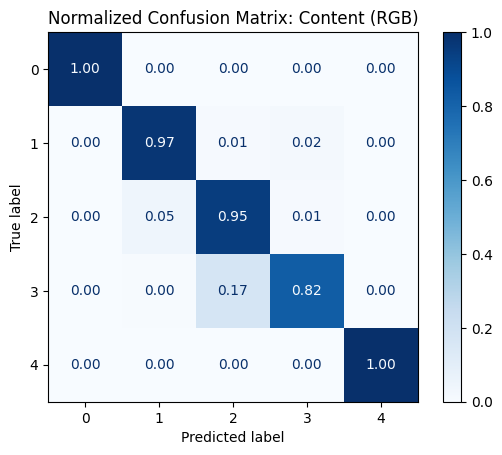

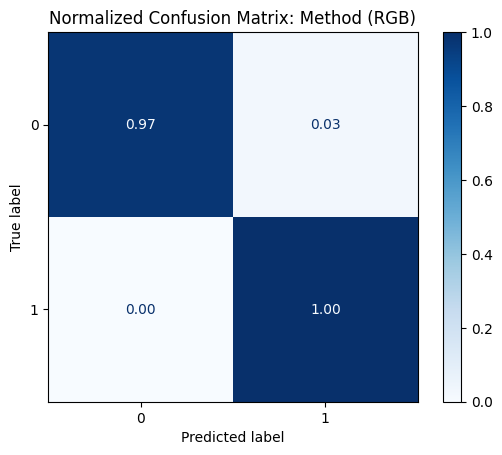

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion(cm, title, save_path):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots()
    disp.plot(cmap='Blues', ax=ax, values_format=".2f")  # ← 여기서 %.2f 포맷 적용
    plt.title(title)
    plt.savefig(save_path, format='svg')
    plt.show()

# confusion matrix_content
cm_content = confusion_matrix(y_true_all_content, y_pred_all_content, normalize='true')
plot_confusion(cm_content, "Normalized Confusion Matrix: Content (RGB)", f"{save_dir}/confusion_matrix_content_1080_v3.svg")

# confusion matrix_dispersion method
cm_method = confusion_matrix(y_true_all_method, y_pred_all_method, normalize='true')
plot_confusion(cm_method, "Normalized Confusion Matrix: Method (RGB)", f"{save_dir}/confusion_matrix_method_1080_v3.svg")


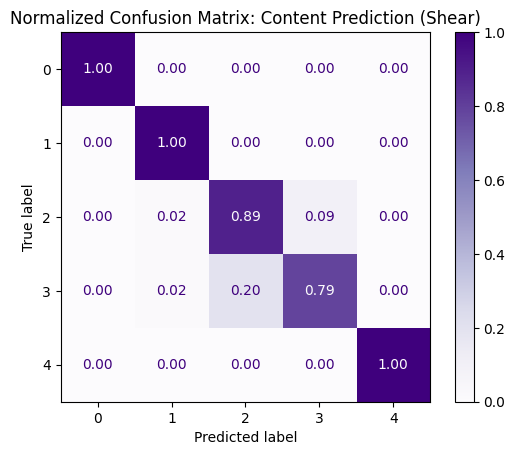

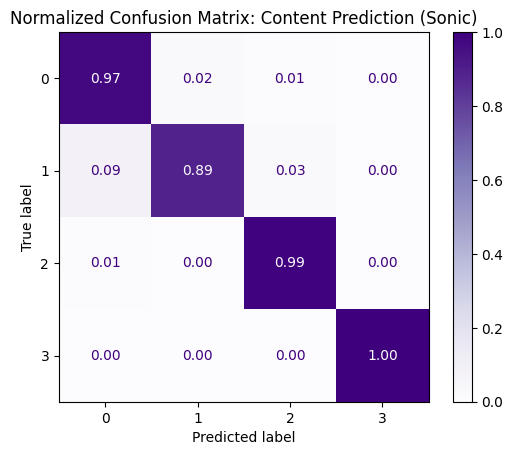

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion(cm, title, save_path):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots()
    disp.plot(cmap='Purples', ax=ax, values_format=".2f")
    plt.title(title)
    plt.savefig(save_path, format='svg')
    plt.show()

shear_indices = [i for i, label in enumerate(y_true_all_method) if label == 0]
sonic_indices = [i for i, label in enumerate(y_true_all_method) if label == 1]

# confusion matrix_shear-mixed
y_true_shear = np.array(y_true_all_content)[shear_indices]
y_pred_shear = np.array(y_pred_all_content)[shear_indices]
cm_shear = confusion_matrix(y_true_shear, y_pred_shear, normalize='true')
plot_confusion(cm_shear, "Normalized Confusion Matrix: Content Prediction (Shear)", f"{save_dir}/confusion_matrix_content_shear.svg")

# confusion matrix_sonication
y_true_sonic = np.array(y_true_all_content)[sonic_indices]
y_pred_sonic = np.array(y_pred_all_content)[sonic_indices]
cm_sonic = confusion_matrix(y_true_sonic, y_pred_sonic, normalize='true')
plot_confusion(cm_sonic, "Normalized Confusion Matrix: Content Prediction (Sonic)", f"{save_dir}/confusion_matrix_content_sonic.svg")


# Interpretation

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import pickle

save_dir = "/content/drive/MyDrive/Results/rgb_resized"
os.makedirs(save_dir, exist_ok=True)
model_base_name = "2dcnn_rgb_branching_896"
target_fold_idx = 3  # Select fold number

# Data preparation
SMALL_TRAIN, SMALL_TEST = outer_fold_sets[target_fold_idx]
x_test, y_test_content, y_test_method = prepare_rgb_image_test_dataset(
    SMALL_TRAIN, SMALL_TEST, target_size=(224, 224)
)

# Label encoding
le_method = LabelEncoder()
le_content = LabelEncoder()

unique_content_labels = sorted(list(set(y_test_content)))
unique_method_labels = sorted(list(set(y_test_method)))

le_content.fit(unique_content_labels)
le_method.fit(unique_method_labels)

y_test_method_encoded = le_method.transform(y_test_method)
y_test_content_encoded = le_content.transform(y_test_content)

# Load model
model_name_folded = f"{model_base_name}_fold{target_fold_idx}"
best_model_path = f"{save_dir}/best_{model_name_folded}_model.keras"
model = tf.keras.models.load_model(best_model_path, compile=False)

# Prediction
method_pred, content_pred = model.predict(x_test)
method_pred_label = (method_pred > 0.5).astype(int).flatten()
content_pred_label = np.argmax(content_pred, axis=1)

# Save performance
acc_content = accuracy_score(y_test_content_encoded, content_pred_label)
f1_content = f1_score(y_test_content_encoded, content_pred_label, average='macro')
acc_method = accuracy_score(y_test_method_encoded, method_pred_label)
f1_method = f1_score(y_test_method_encoded, method_pred_label, average='macro')

print(f"\n Fold {target_fold_idx} Performance")
print(f"Content_Accuracy: {acc_content:.3f}, Macro F1: {f1_content:.3f}")
print(f"Method_Accuracy: {acc_method:.3f}, Macro F1: {f1_method:.3f}")

# Predictions
y_true_all_content = list(y_test_content_encoded)
y_pred_all_content = list(content_pred_label)
y_true_all_method = list(y_test_method_encoded)
y_pred_all_method = list(method_pred_label)
x_all_test = list(x_test)


In [ ]:
# Grad-CAM_content prediction

def generate_gradcam(model, image, target_class, layer_name='conv2d_107', output_index=1):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output[output_index]]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))

        if output_index == 1:  # content branch (softmax)
            loss = predictions[:, target_class]
        elif output_index == 0:  # method branch (sigmoid)
            loss = predictions[:, 0]  # 1 dimensional

    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)

    cam = tf.maximum(cam, 0)
    cam = cam / (tf.reduce_max(cam) + 1e-8)
    cam = tf.image.resize(cam[..., tf.newaxis], image.shape[:2])
    return cam.numpy().squeeze()


def show_gradcam(image, cam, title):
    plt.figure(figsize=(10, 5))

    # original image
    plt.subplot(1, 2, 1)
    plt.imshow(image.astype(np.uint8))
    plt.title("Original Image")
    plt.axis('off')

    # Grad-CAM overlay
    plt.subplot(1, 2, 2)
    plt.imshow(image.astype(np.uint8))
    plt.imshow(cam, cmap='jet', alpha=0.35)  # ← alpha 낮춰서 원본이 더 잘 보이게
    plt.title(title)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Name of the last Conv2D layer
conv_layers = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
print("Conv2D layers:", conv_layers)
print("Use this for Grad-CAM:", conv_layers[-1])

# Labels
target_method = 1
target_content = 4
wrong_content = 3

# Indexing correct samples
correct_indices = [
    i for i, (yt_m, yp_m, yt_c, yp_c) in enumerate(zip(
        y_true_all_method, y_pred_all_method,
        y_true_all_content, y_pred_all_content
    ))
    if yt_m == target_method and yp_m == target_method and
       yt_c == target_content and yp_c == target_content
]

# Indexing incorrect samples
incorrect_indices = [
    i for i, (yt_m, yp_m, yt_c, yp_c) in enumerate(zip(
        y_true_all_method, y_pred_all_method,
        y_true_all_content, y_pred_all_content
    ))
    if yt_m == target_method and yp_m == target_method and
       yt_c == target_content and yp_c == wrong_content
]

print(f"\n Showing up to correct Grad-CAMs...")
for i, idx in enumerate(correct_indices[20:26]):
    image = x_test[idx]
    cam = generate_gradcam(model, image, target_class=target_content)
    show_gradcam(image, cam, f" Correct {i+1}: 0.1% → 0.1% (Shear)")


In [ ]:
# Grad-CAM_method prediction

def generate_gradcam(model, image, target_class, layer_name='conv2d_113', output_index=1):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output[output_index]]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        if output_index == 1:  # content branch (softmax)
            loss = predictions[:, target_class]
        elif output_index == 0:  # method branch (sigmoid)
            loss = predictions[:, 0]  # binary classification → always index 0

    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)

    cam = tf.maximum(cam, 0)
    cam = cam / (tf.reduce_max(cam) + 1e-8)
    cam = tf.image.resize(cam[..., tf.newaxis], image.shape[:2])
    return cam.numpy().squeeze()

def show_gradcam(image, cam, title):
    plt.figure(figsize=(10, 5))

    # original image
    plt.subplot(1, 2, 1)
    plt.imshow(image.astype(np.uint8))
    plt.title("Original Image")
    plt.axis('off')

    # Grad-CAM overlay
    plt.subplot(1, 2, 2)
    plt.imshow(image.astype(np.uint8))
    plt.imshow(cam, cmap='jet', alpha=0.35)
    plt.title(title)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


target_method = 0

correct_indices_method = [
    i for i, (yt_m, yp_m) in enumerate(zip(y_true_all_method, y_pred_all_method))
    if yt_m == target_method and yp_m == target_method
]

print(f"\n Showing up to correct Grad-CAMs for method prediction (Shear)...")
for i, idx in enumerate(correct_indices_method[:6]):
    image = x_test[idx]
    cam = generate_gradcam(model, image, target_class=target_method, output_index=0)  # method branch
    show_gradcam(image, cam, f"Method Correct {i+1}: Shear → Shear")